In [1]:
!pip install pyspark
!pip install bs4
import nltk 
nltk.download('stopwords')

    100% |████████████████████████████████| 215.7MB 192kB/s 
    100% |████████████████████████████████| 204kB 32.0MB/s 
  Running setup.py bdist_wheel for pyspark ... done
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark
scikit-umfpack 0.3.2 has requirement numpy>=1.15.3, but you'll have numpy 1.15.1 which is incompatible.
menpo 0.8.1 has requirement matplotlib<2.0,>=1.4, but you'll have matplotlib 2.2.3 which is incompatible.
menpo 0.8.1 has requirement pillow<5.0,>=3.0, but you'll have pillow 5.2.0 which is incompatible.
menpo 0.8.1 has requirement scipy<1.0,>=0.16, but you'll have scipy 1.1.0 which is incompatible.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 102kB 5.8MB/s 
  Running setup.py bdist_wheel for bs4 ... done
  Stored in directory: /root/.cache

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

from pyspark.sql.types import StructType, StructField, StringType
from pyspark.sql import Row
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkConf, SparkContext
import os
from pyspark.ml import Pipeline
import time

Using TensorFlow backend.


In [3]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

In [5]:
spark = SparkSession \
    .builder \
    .appName("EToSA") \
    .getOrCreate()

spark.conf.set("spark.sql.execution.arrow.enabled", "true")

sc = SparkContext.getOrCreate()

In [6]:
sc

<SparkContext master=local[*] appName=EToSA>

In [7]:
from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, HasRegParam
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from nltk.corpus import stopwords

In [8]:
#Convert to lower
class ConvertToLower(Transformer, HasInputCol, HasOutputCol):

    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(ConvertToLower, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def _transform(self, dataset):

        def f(s):
            cleaned_post = s.lower()
            return cleaned_post

        t = StringType()
        out_col = self.getOutputCol()
        in_col = dataset[self.getInputCol()]
        return dataset.withColumn(out_col, udf(f, t)(in_col))

In [9]:
class RemoveHTMLTags(Transformer, HasInputCol, HasOutputCol):

    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(RemoveHTMLTags, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def _transform(self, dataset):

        def f(s):
            newString = s
            newString = BeautifulSoup(newString, "html").text
            cleaned_post = newString
            return cleaned_post

        t = StringType()
        out_col = self.getOutputCol()
        in_col = dataset[self.getInputCol()]
        return dataset.withColumn(out_col, udf(f, t)(in_col))

In [10]:
#Contraction Mapping
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

class RemoveUnwantedCharacters(Transformer, HasInputCol, HasOutputCol):

    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(RemoveUnwantedCharacters, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def _transform(self, dataset):

        def f(s):
            newString = s
            newString = re.sub(r'\([^)]*\)', '', newString) # text between parenthesis
            newString = re.sub('"','', newString) #punctuation
            newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
            newString = re.sub(r"'s\b","",newString) #apostrophe
            newString = re.sub("[^a-zA-Z]", " ", newString) #remove digits and special characters
            newString = re.sub('[m]{2,}', 'mm', newString) #punctuation
            cleaned_post = newString
            return cleaned_post

        t = StringType()
        out_col = self.getOutputCol()
        in_col = dataset[self.getInputCol()]
        return dataset.withColumn(out_col, udf(f, t)(in_col))


In [11]:
stop_words = set(stopwords.words('english')) 

class RemoveStopWords(Transformer, HasInputCol, HasOutputCol):

    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(RemoveStopWords, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def _transform(self, dataset):

        def f(s):
            newString = s
            tokens = [w for w in newString.split() if not w in stop_words] #stopwords
            words=[]
            for i in tokens:
                words.append(i)   
            cleaned_post = (" ".join(words)).strip()
            return cleaned_post

        t = StringType()
        out_col = self.getOutputCol()
        in_col = dataset[self.getInputCol()]
        return dataset.withColumn(out_col, udf(f, t)(in_col))

In [12]:
class RemoveShortWords(Transformer, HasInputCol, HasOutputCol, HasRegParam):

    @keyword_only
    def __init__(self, inputCol=None, outputCol=None, regParam=None):
        super(RemoveShortWords, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None, regParam=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def _transform(self, dataset):

        def f(s):
            newString = s
            tokens = newString.split()
            long_words=[]
            tval = int(self.getRegParam())
            for i in tokens:
                if len(i)>tval:                                                 #removing short word
                    long_words.append(i)   
            cleaned_post = (" ".join(long_words)).strip()
            return cleaned_post

        t = StringType()
        out_col = self.getOutputCol()
        in_col = dataset[self.getInputCol()]
        return dataset.withColumn(out_col, udf(f, t)(in_col))
    
    def setThreshold(self, value):
        return self._set(thresholdValue=value)

    def getThreshold(self):
        return self.getOrDefault(self.thresholdValue)


In [16]:
schema = StructType([
    StructField("title", StringType(), True),
    StructField("abstract", StringType(), True)
])
total_df = spark.createDataFrame([], schema)

ingestion_start_time = time.time()

for file_name in os.listdir("/floyd/input/sdata250gb/"):
    if file_name != '._1.json':
        print(file_name)
        df = spark.read.json("/floyd/input/sdata250gb/"+file_name)
        dataNode = df.select("title", "abstract")
        total_df = total_df.union(dataNode)
#for file_name in os.listdir("/floyd/input/sdata250gb1/"):
##    print(file_name)
 #   df = spark.read.json("/floyd/input/sdata250gb1/"+file_name)
 #   dataNode = df.select("title", "abstract")
 #   total_df = total_df.union(dataNode)
#for file_name in os.listdir("/floyd/input/sdata250gb3/"):
#    print(file_name)
#    df = spark.read.json("/floyd/input/sdata250gb3/"+file_name)
#    dataNode = df.select("title", "abstract")
#    total_df = total_df.union(dataNode)
#for file_name in os.listdir("/floyd/input/sdata250gb4/"):
#    print(file_name)
#    df = spark.read.json("/floyd/input/sdata250gb4/"+file_name)
#    dataNode = df.select("title", "abstract")
#    total_df = total_df.union(dataNode)
#for file_name in os.listdir("/floyd/input/sdata250gb5/"):
#    if file_name != '._65.json':
#        print(file_name)
#       dataNode = df.select("title", "abstract")
#        total_df = total_df.union(dataNode)


ingestion_time = time.time() - ingestion_start_time
print("Data Ingestion Time:")
print("--- %s seconds ---" % ingestion_time)

total_df.count()

19.json
8.json
14.json
7.json
12.json
2.json
6.json
17.json
18.json
10.json
1.json
5.json
9.json
16.json
Data Ingestion Time:
--- 25.797974586486816 seconds ---


128873

In [17]:
preprocess_start_time = time.time()

#remove null values
total_df=total_df.filter(total_df.title.isNotNull())
total_df=total_df.filter(total_df.abstract.isNotNull())

#remove duplicates
total_df = total_df.dropDuplicates(['abstract'])
preclean_time = time.time() - preprocess_start_time
print("Pre-Cleaning Time : \n")
print("--- %s seconds ---" % preclean_time)

convert_to_lower_title = ConvertToLower(inputCol="title", outputCol="lower_title")
convert_remove_html_tags = RemoveHTMLTags(inputCol=convert_to_lower_title.getOutputCol(), outputCol="text_title")
convert_remove_unwanted_characters = RemoveUnwantedCharacters(inputCol=convert_remove_html_tags.getOutputCol(), outputCol="cleaned_title")
clean_text_title = RemoveShortWords(inputCol=convert_remove_unwanted_characters.getOutputCol(), outputCol="final_title", regParam=1)
pipeline = Pipeline(stages=[
    convert_to_lower_title,
    convert_remove_html_tags,
    convert_remove_unwanted_characters,
    clean_text_title
    ])
convert_to_lower_abstract = ConvertToLower(inputCol="abstract", outputCol="lower_abstract")
convert_remove_html_tags_abstract = RemoveHTMLTags(inputCol=convert_to_lower_abstract.getOutputCol(), outputCol="text_abstract")
convert_remove_unwanted_characters_abstract = RemoveUnwantedCharacters(inputCol=convert_remove_html_tags_abstract.getOutputCol(), outputCol="cleaned_abstract")
convert_remove_stop_words = RemoveStopWords(inputCol=convert_remove_unwanted_characters_abstract.getOutputCol(), outputCol="wo_stopwords_abstract")
clean_text_abstract = RemoveShortWords(inputCol=convert_remove_stop_words.getOutputCol(), outputCol="final_abstract", regParam=1)
pipeline_abstract = Pipeline(stages=[
    convert_to_lower_abstract,
    convert_remove_html_tags_abstract,
    convert_remove_unwanted_characters_abstract,
    convert_remove_stop_words,
    clean_text_abstract
    ])

model = pipeline.fit(total_df)
model_abstract = pipeline_abstract.fit(total_df)

clean_start_time = time.time()
cleaned_title = model.transform(total_df)
cleaned_abstract = model_abstract.transform(total_df)
clean_time = time.time() - clean_start_time
print("Cleaning Time:")
print("--- %s seconds ---" % clean_time)

postclean_start_time = time.time()

cleaned_title = cleaned_title.select("title", "abstract", "final_title").toPandas()
cleaned_abstract = cleaned_abstract.select("title", "abstract", "final_abstract").toPandas()
data = pd.merge(cleaned_title, cleaned_abstract, on=['title','abstract'])
#data = data.drop(['title', 'abstract'], axis=1)

data = data.rename(columns={"title": "summary", "abstract": "text"})
data = data.rename(columns={"final_title": "cleaned_summary", "final_abstract": "cleaned_text"})

data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

postclean_time = time.time() - postclean_start_time
print("Post-Cleaning Time : \n")
print("--- %s seconds ---" % postclean_time)
total_preprocess_time = time.time() - preprocess_start_time
print("Total Preprocessing Time: \n")
print("--- %s seconds ---" % total_preprocess_time)

Pre-Cleaning Time : 

--- 0.010288238525390625 seconds ---
Cleaning Time:
--- 0.10741662979125977 seconds ---
Post-Cleaning Time : 

--- 162.54743146896362 seconds ---
Total Preprocessing Time: 

--- 162.66801238059998 seconds ---


In [18]:
data.count()

summary            88709
text               88709
cleaned_summary    88709
cleaned_text       88709
dtype: int64

In [ ]:
#data = data.dropna()
#datay = data.sort_values(by='summary', ascending=False)

In [ ]:
#datay.to_csv('withspark_1.csv')
#datax = pd.read_csv("withoutspark.csv") 

In [96]:
datay['cleaned_summary'].isin(datax['cleaned_summary']).value_counts()

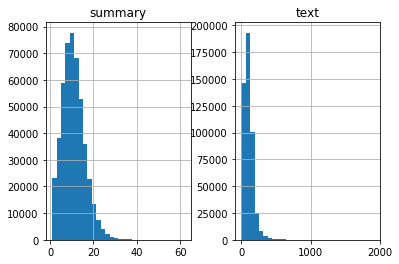

In [97]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [98]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=20):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=200):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9545197352271829
0.9265613233648281


In [99]:
max_text_len=200
max_summary_len=20

In [100]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [101]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [102]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [103]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [104]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 64.30920149586076
Total Coverage of rare words: 0.8832953040415562


In [105]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [106]:
x_voc

117009

In [107]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [108]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 74.6160369358334
Total Coverage of rare words: 3.11067772226377


In [109]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [110]:
y_tokenizer.word_counts['sostok'],len(y_tr)   

(384053, 384053)

In [111]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [112]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [113]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 100)     11700900    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 200, 300), ( 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
lstm_1 (LS

In [114]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [115]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [116]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=1,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 383002 samples, validate on 42536 samples
383002/383002 [==============================] - 4170s 11ms/sample - loss: nan - val_loss: nan


In [ ]:
#model_dev_time = time.time() - start_time
#print("--- %s seconds ---" % model_dev_time)

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString


In [ ]:
inference_start_time = time.time()

reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])
d = []
for i in range(0,1):
#    print("Review:",seq2text(x_tr[i]))
#    print("Original summary:",seq2summary(y_tr[i]))
#    print("Generated summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
#    print("\n")
    d.append((seq2summary(y_tr[i]), decode_sequence(x_tr[i].reshape(1,max_text_len))))

total_inference_time = time.time() - inference_start_time
print("Total Inference Time : \n")
print("--- %s seconds ---" % total_inference_time)
pd.DataFrame(d, columns=('O_Summary', 'G_Summary'))

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
for i in range(0,40):
    original = d[i][0].split()
    generated = d[i][1].split()
    reference = [original]
    candidate = generated
    score = sentence_bleu(reference, candidate)
    print(score)

In [ ]:
!pip install rouge

In [ ]:
from rouge import Rouge
rouge = Rouge()
scores = rouge.get_scores(d[5][1], d[5][0])
scores